In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)
sns.set(style = 'whitegrid')

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string
import re
from nltk.probability import FreqDist

from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## import data


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ematerai_ALL.xlsx')

In [ ]:
df.head()

,day_name,tanggal,month,year,date,time,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,tag
0,Thu,10,Nov,2022,2022-11-10,09:48:14,"@peruri_id halo kak, ini udah bisa login tapi...",0,15,2,4,in,53670404,1590642477673112064,heeyowik,https://twitter.com/heeyowik/status/1590642477...,ematerai
1,Tue,26,Sep,2023,2023-09-26,13:03:36,Daftar akun ematerai kok gagal terus yah? Ada ...,0,12,0,4,in,1191943053046624000,1706655761072546048,terban9jauh,https://twitter.com/terban9jauh/status/1706655...,ematerai
2,Sat,7,Oct,2023,2023-10-07,02:11:58,@skillacademy_id Haloooo kak pembubuhan emater...,0,10,0,0,in,251535471,1710476353584185088,tyatehhtya,https://twitter.com/tyatehhtya/status/17104780...,ematerai
3,Sat,7,Oct,2023,2023-10-07,02:04:03,ematerai gabisa udah pakai tiga web-commerce p...,0,10,0,0,in,1068399359648092032,1710476048121390080,husnulhatiimaah,https://twitter.com/husnulhatiimaah/status/171...,ematerai
4,Sat,5,Aug,2023,2023-08-05,11:57:19,Ijazah digital yang dibuat oleh Peruri dapat l...,1,10,1,7,in,3326010492,1687794914162355968,peruri_id,https://twitter.com/peruri_id/status/168779491...,ematerai


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   day_name             1515 non-null   object        
 1   tanggal              1515 non-null   int64         
 2   month                1515 non-null   object        
 3   year                 1515 non-null   int64         
 4   date                 1515 non-null   datetime64[ns]
 5   time                 1515 non-null   object        
 6   full_text            1515 non-null   object        
 7   quote_count          1515 non-null   int64         
 8   reply_count          1515 non-null   int64         
 9   retweet_count        1515 non-null   int64         
 10  favorite_count       1515 non-null   int64         
 11  lang                 1515 non-null   object        
 12  user_id_str          1515 non-null   int64         
 13  conversation_id_str  1515 non-nul

## EDA

In [ ]:
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objects as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import plotly.express as px

In [ ]:
total_tweet = df.groupby('date')['day_name'].count()

fig = go.Figure([go.Scatter(x=total_tweet.index, y=total_tweet.values)])
fig.show(renderer="colab")

In [ ]:
dfg = df.groupby(['username']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()
fig = px.histogram(dfg, x='username', y = 0)
fig.show(renderer="colab")

## cleansing

In [ ]:
df_2 = df[['full_text']]

In [ ]:
tweet = list(df_2['full_text'])

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in indonesia.
stopwordlist = ["nya","ya","yg","ada","adalah","adanya","adapun","agak","agaknya","agar","akan","akankah","akhir","akhiri","akhirnya","aku","akulah","amat","amatlah","anda","andalah","antar","antara","antaranya","apa","apaan","apabila","apakah","apalagi","apatah","artinya","asal","asalkan","atas","atau","ataukah","ataupun","awal","awalnya","bagai","bagaikan","bagaimana","bagaimanakah","bagaimanapun","bagi","bagian","bahkan","bahwa","bahwasanya","baik","bakal","bakalan","balik","banyak",
                "bapak","baru","bawah","beberapa","begini","beginian","beginikah","beginilah","begitu","begitukah","begitulah","begitupun","bekerja","belakang","belakangan","belum","belumlah","benar","benarkah","benarlah","berada","berakhir","berakhirlah","berakhirnya","berapa","berapakah","berapalah","berapapun","berarti","berawal","berbagai","berdatangan","beri","berikan","berikut","berikutnya","berjumlah","berkali-kali","berkata","berkehendak","berkeinginan","berkenaan","berlainan","berlalu","berlangsung","berlebihan","bermacam","bermacam-macam","bermaksud","bermula","bersama",
                "bersama-sama","bersiap","bersiap-siap","bertanya","bertanya-tanya","berturut","berturut-turut","bertutur","berujar","berupa","besar","betul","betulkah","biasa","biasanya","bila","bilakah","bisa","bisakah","boleh","bolehkah","bolehlah","buat","bukan","bukankah","bukanlah","bukannya","bulan","bung","cara","caranya","cukup","cukupkah","cukuplah","cuma","dahulu","dalam","dan","dapat","dari","daripada","datang","dekat","demi","demikian","demikianlah","dengan","depan","di","dia","diakhiri",
                "diakhirinya","dialah","diantara","diantaranya","diberi","diberikan","diberikannya","dibuat","dibuatnya","didapat","didatangkan","digunakan","diibaratkan","diibaratkannya","diingat","diingatkan","diinginkan","dijawab","dijelaskan","dijelaskannya","dikarenakan","dikatakan","dikatakannya","dikerjakan","diketahui","diketahuinya","dikira","dilakukan","dilalui","dilihat","dimaksud","dimaksudkan","dimaksudkannya","dimaksudnya","diminta","dimintai","dimisalkan","dimulai","dimulailah","dimulainya","dimungkinkan","dini","dipastikan","diperbuat","diperbuatnya","dipergunakan","diperkirakan","diperlihatkan","diperlukan","diperlukannya","dipersoalkan","dipertanyakan",
                "dipunyai","diri","dirinya","disampaikan","disebut","disebutkan","disebutkannya","disini","disinilah","ditambahkan","ditandaskan","ditanya","ditanyai","ditanyakan","ditegaskan","ditujukan","ditunjuk","ditunjuki","ditunjukkan","ditunjukkannya","ditunjuknya","dituturkan","dituturkannya","diucapkan","diucapkannya","diungkapkan","dong","dua","dulu","empat","enggak","enggaknya","entah","entahlah","guna","gunakan","hal","hampir","hanya","hanyalah","hari","harus","haruslah","harusnya","hendak","hendaklah","hendaknya","hingga","ia",
                "ialah","ibarat","ibaratkan","ibaratnya","ibu","ikut","ingat","ingat-ingat","ingin","inginkah","inginkan","ini","inikah","inilah","itu","itukah","itulah","jadi","jadilah","jadinya","jangan","jangankan","janganlah","jauh","jawab","jawaban","jawabnya","jelas","jelaskan","jelaslah","jelasnya","jika","jikalau","juga","jumlah","jumlahnya","justru","kala","kalau","kalaulah","kalaupun","kalian","kami","kamilah","kamu","kamulah","kan","kapan","kapankah",
                "kapanpun","karena","karenanya","kasus","kata","katakan","katakanlah","katanya","ke","keadaan","kebetulan","kecil","kedua","keduanya","keinginan","kelamaan","kelihatan","kelihatannya","kelima","keluar","kembali","kemudian","kemungkinan","kemungkinannya","kenapa","kepada","kepadanya","kesampaian","keseluruhan","keseluruhannya","keterlaluan","ketika","khususnya","kini","kinilah","kira","kira-kira","kiranya","kita","kitalah","kok","kurang","lagi","lagian","lah","lain","lainnya","lalu",
                "lama","lamanya","lanjut","lanjutnya","lebih","lewat","lima","luar","macam","maka","makanya","makin","malah","malahan","mampu","mampukah","mana","manakala","manalagi","masa","masalah","masalahnya","masih","masihkah","masing","masing-masing","mau","maupun","melainkan","melakukan","melalui","melihat","melihatnya","memang","memastikan","memberi","memberikan","membuat","memerlukan","memihak","meminta","memintakan","memisalkan",
                "memperbuat","mempergunakan","memperkirakan","memperlihatkan","mempersiapkan","mempersoalkan","mempertanyakan","mempunyai","memulai","memungkinkan","menaiki","menambahkan","menandaskan","menanti","menanti-nanti","menantikan","menanya","menanyai","menanyakan","mendapat","mendapatkan","mendatang","mendatangi","mendatangkan","menegaskan","mengakhiri","mengapa","mengatakan","mengatakannya","mengenai","mengerjakan","mengetahui","menggunakan","menghendaki","mengibaratkan","mengibaratkannya","mengingat","mengingatkan","menginginkan","mengira","mengucapkan","mengucapkannya","mengungkapkan","menjadi","menjawab","menjelaskan",
                "menuju","menunjuk","menunjuki","menunjukkan","menunjuknya","menurut","menuturkan","menyampaikan","menyangkut","menyatakan","menyebutkan","menyeluruh","menyiapkan","merasa","mereka","merekalah","merupakan","meski","meskipun","meyakini","meyakinkan","minta","mirip","misal","misalkan","misalnya","mula","mulai","mulailah","mulanya","mungkin","mungkinkah","nah","naik","namun","nanti","nantinya","nyaris","nyatanya","oleh","olehnya","pada","padahal","padanya",
                "pak","paling","panjang","pantas","para","pasti","pastilah","penting","pentingnya","per","percuma","perlu","perlukah","perlunya","pernah","persoalan","pertama","pertama-tama","pertanyaan","pertanyakan","pihak","pihaknya","pukul","pula","pun","punya","rasa","rasanya","rata","rupanya","saat","saatnya","saja","sajalah","saling","sama","sama-sama","sambil","sampai","sampai-sampai","sampaikan","sana","sangat","sangatlah","satu","saya",
                "sayalah","se","sebab","sebabnya","sebagai","sebagaimana","sebagainya","sebagian","sebaik","sebaik-baiknya","sebaiknya","sebaliknya","sebanyak","sebegini","sebegitu","sebelum","sebelumnya","sebenarnya","seberapa","sebesar","sebetulnya","sebisanya","sebuah","sebut","sebutlah","sebutnya","secara","secukupnya","sedang","sedangkan","sedemikian","sedikit","sedikitnya","seenaknya","segala","segalanya","segera","seharusnya","sehingga","seingat","sejak","sejauh","sejenak","sejumlah","sekadar","sekadarnya","sekali","sekali-kali","sekalian","sekaligus",
                "sekalipun","sekarang","sekarang","sekecil","seketika","sekiranya","sekitar","sekitarnya","sekurang-kurangnya","sekurangnya","sela","selain","selaku","selalu","selama","selama-lamanya","selamanya","selanjutnya","seluruh","seluruhnya","semacam","semakin","semampu","semampunya","semasa","semasih","semata","semata-mata","semaunya","sementara","semisal","semisalnya","sempat","semua","semuanya","semula","sendiri","sendirian","sendirinya","seolah",
                "seolah-olah","seorang","sepanjang","sepantasnya","sepantasnyalah","seperlunya","seperti","sepertinya","sepihak","sering","seringnya","serta","serupa","sesaat","sesama","sesampai","sesegera","sesekali","seseorang","sesuatu","sesuatunya","sesudah","sesudahnya","setelah","setempat","setengah","seterusnya","setiap","setiba","setibanya","setidak-tidaknya","setidaknya","setinggi","seusai","sewaktu","siap","siapa","siapakah","siapapun","sini","sinilah",
                "soal","soalnya","suatu","sudah","sudahkah","sudahlah","supaya","tadi","tadinya","tahu","tahun","tak","tambah","tambahnya","tampak","tampaknya","tandas","tandasnya","tanpa","tanya","tanyakan","tanyanya","tapi","tegas","tegasnya","telah","tempat","tengah","tentang","tentu","tentulah","tentunya","tepat","terakhir","terasa","terbanyak","terdahulu","terdapat","terdiri","terhadap","terhadapnya","teringat","teringat-ingat","terjadi","terjadilah","terjadinya","terkira","terlalu","terlebih","terlihat","termasuk","ternyata","tersampaikan","tersebut","tersebutlah","tertentu","tertuju","terus","terutama","tetap","tetapi","tiap","tiba",
                "tiba-tiba","tidak","tidakkah","tidaklah","tiga","tinggi","toh","tunjuk","turut","tutur","tuturnya","ucap","ucapnya","ujar","ujarnya","umum","umumnya","ungkap","ungkapnya","untuk","usah","usai","waduh","wah","wahai","waktu","waktunya","walau","walaupun","wong","yaitu","yakin","yakni","yang"]

In [ ]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,'',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # # Replace @USERNAME to 'USER'.
        # tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist:
              if len(word)>1:
                  # Lemmatizing the word.
                  word = wordLemm.lemmatize(word)
                  tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import time
t = time.time()
processedtext = preprocess(tweet)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 1 seconds


In [ ]:
result = pd.DataFrame(processedtext)

In [ ]:
result.head()

,0
0,peruri id halo kak udah login ematerai hilang ...
1,daftar akun ematerai gagal yah
2,skillacademy id haloo kak pembubuhan ematerai ...
3,ematerai gabisa udah pakai web commerce bermas...
4,ijazah digital peruri langsung diperiksa keasl...


In [ ]:
df['processedtext'] = processedtext

In [ ]:
df.head()

,day_name,tanggal,month,year,date,time,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,tag,processedtext
0,Thu,10,Nov,2022,2022-11-10,09:48:14,"@peruri_id halo kak, ini udah bisa login tapi...",0,15,2,4,in,53670404,1590642477673112064,heeyowik,https://twitter.com/heeyowik/status/1590642477...,ematerai,peruri id halo kak udah login ematerai hilang ...
1,Tue,26,Sep,2023,2023-09-26,13:03:36,Daftar akun ematerai kok gagal terus yah? Ada ...,0,12,0,4,in,1191943053046624000,1706655761072546048,terban9jauh,https://twitter.com/terban9jauh/status/1706655...,ematerai,daftar akun ematerai gagal yah
2,Sat,7,Oct,2023,2023-10-07,02:11:58,@skillacademy_id Haloooo kak pembubuhan emater...,0,10,0,0,in,251535471,1710476353584185088,tyatehhtya,https://twitter.com/tyatehhtya/status/17104780...,ematerai,skillacademy id haloo kak pembubuhan ematerai ...
3,Sat,7,Oct,2023,2023-10-07,02:04:03,ematerai gabisa udah pakai tiga web-commerce p...,0,10,0,0,in,1068399359648092032,1710476048121390080,husnulhatiimaah,https://twitter.com/husnulhatiimaah/status/171...,ematerai,ematerai gabisa udah pakai web commerce bermas...
4,Sat,5,Aug,2023,2023-08-05,11:57:19,Ijazah digital yang dibuat oleh Peruri dapat l...,1,10,1,7,in,3326010492,1687794914162355968,peruri_id,https://twitter.com/peruri_id/status/168779491...,ematerai,ijazah digital peruri langsung diperiksa keasl...


In [ ]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", " ", text)

result['full_text'] = result[0].apply(remove_number)

In [ ]:
#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

result['full_text'] = result['full_text'].apply(remove_punctuation)

In [ ]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", " ", text)

result['full_text'] = result['full_text'].apply(remove_singl_char)

## slang

In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 115MB/s]


In [ ]:
slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

In [ ]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

In [ ]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}

In [ ]:
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [ ]:
!pip install textblob

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from textblob import TextBlob
clean_text = []
for review in result['full_text']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [ ]:
clean_text

['peruri id halo kak sudah login ematerai hilang web error whatsapp email kemarin nomor respons bantu',
 'daftar akun ematerai gagal ya',
 'skillacademy id halo kak pembubuhan ematerai ya sudah jam malam sampai pagi antrian mohon bantuannya',
 'ematerai tidak bisa sudah pakai web commerce bermasalah skill academy prose pembubuhan belum unduh tadi malam ematerai live tidak unggah gramedia tidak login',
 'ijazah digital peruri langsung diperiksa keasliannya memindai qr code menampilkan data nama pemilik ijazah nilai ipk tanggal kelulusan data pribadi muncul aman',
 'kasian daftar melalui sscasn hari unggah dokumen disertai eh sekarang website ematerai live error sekarang dpk hari unggah ematerai pilihannya tidak',
 'drama sih server cpns siang down bapak sudah web ematerai tidak aku bapak sudah sudah unduh unggah file seperti begini solusinya ya kayak begini tidak bkngoid cpns bukan sscasn ematerai',
 'sengaja saya begadangin makin saja pembubuhan tidak bisa kuota keterangan tersedia saj

In [ ]:
df['normalization'] = clean_text

In [ ]:
result['normalization'] = clean_text

In [ ]:
df.head()

,day_name,tanggal,month,year,date,time,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,tag,processedtext,normalization
0,Thu,10,Nov,2022,2022-11-10,09:48:14,"@peruri_id halo kak, ini udah bisa login tapi...",0,15,2,4,in,53670404,1590642477673112064,heeyowik,https://twitter.com/heeyowik/status/1590642477...,ematerai,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak sudah login ematerai hilang...
1,Tue,26,Sep,2023,2023-09-26,13:03:36,Daftar akun ematerai kok gagal terus yah? Ada ...,0,12,0,4,in,1191943053046624000,1706655761072546048,terban9jauh,https://twitter.com/terban9jauh/status/1706655...,ematerai,daftar akun ematerai gagal yah,daftar akun ematerai gagal ya
2,Sat,7,Oct,2023,2023-10-07,02:11:58,@skillacademy_id Haloooo kak pembubuhan emater...,0,10,0,0,in,251535471,1710476353584185088,tyatehhtya,https://twitter.com/tyatehhtya/status/17104780...,ematerai,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id halo kak pembubuhan ematerai y...
3,Sat,7,Oct,2023,2023-10-07,02:04:03,ematerai gabisa udah pakai tiga web-commerce p...,0,10,0,0,in,1068399359648092032,1710476048121390080,husnulhatiimaah,https://twitter.com/husnulhatiimaah/status/171...,ematerai,ematerai gabisa udah pakai web commerce bermas...,ematerai tidak bisa sudah pakai web commerce b...
4,Sat,5,Aug,2023,2023-08-05,11:57:19,Ijazah digital yang dibuat oleh Peruri dapat l...,1,10,1,7,in,3326010492,1687794914162355968,peruri_id,https://twitter.com/peruri_id/status/168779491...,ematerai,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...


In [ ]:
result.head()

,0,full_text,normalization
0,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak sudah login ematerai hilang...
1,daftar akun ematerai gagal yah,daftar akun ematerai gagal yah,daftar akun ematerai gagal ya
2,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id halo kak pembubuhan ematerai y...
3,ematerai gabisa udah pakai web commerce bermas...,ematerai gabisa udah pakai web commerce bermas...,ematerai tidak bisa sudah pakai web commerce b...
4,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...


In [ ]:
# Tokenisasi
def word_tokenize_wrapper(text):
    return word_tokenize(text)

result['tweet_tokenize'] = result['normalization'].apply(word_tokenize_wrapper)

In [ ]:
result.head()

,0,full_text,normalization,tweet_tokenize
0,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak sudah login ematerai hilang...,"[peruri, id, halo, kak, sudah, login, ematerai..."
1,daftar akun ematerai gagal yah,daftar akun ematerai gagal yah,daftar akun ematerai gagal ya,"[daftar, akun, ematerai, gagal, ya]"
2,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id halo kak pembubuhan ematerai y...,"[skillacademy, id, halo, kak, pembubuhan, emat..."
3,ematerai gabisa udah pakai web commerce bermas...,ematerai gabisa udah pakai web commerce bermas...,ematerai tidak bisa sudah pakai web commerce b...,"[ematerai, tidak, bisa, sudah, pakai, web, com..."
4,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...,"[ijazah, digital, peruri, langsung, diperiksa,..."


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
from nltk.corpus import stopwords
list_stopwords = stopwords.words('indonesian')

In [ ]:
#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

result['tweet_clean'] = result['tweet_tokenize'].apply(stopwords_removal)

result.head(10)

,0,full_text,normalization,tweet_tokenize,tweet_clean
0,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak sudah login ematerai hilang...,"[peruri, id, halo, kak, sudah, login, ematerai...","[peruri, id, halo, kak, login, ematerai, hilan..."
1,daftar akun ematerai gagal yah,daftar akun ematerai gagal yah,daftar akun ematerai gagal ya,"[daftar, akun, ematerai, gagal, ya]","[daftar, akun, ematerai, gagal, ya]"
2,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id halo kak pembubuhan ematerai y...,"[skillacademy, id, halo, kak, pembubuhan, emat...","[skillacademy, id, halo, kak, pembubuhan, emat..."
3,ematerai gabisa udah pakai web commerce bermas...,ematerai gabisa udah pakai web commerce bermas...,ematerai tidak bisa sudah pakai web commerce b...,"[ematerai, tidak, bisa, sudah, pakai, web, com...","[ematerai, pakai, web, commerce, bermasalah, s..."
4,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...,"[ijazah, digital, peruri, langsung, diperiksa,...","[ijazah, digital, peruri, langsung, diperiksa,..."
5,kasian daftar p3k via sscasn hr unggah dokumen...,kasian daftar via sscasn hr unggah dokumen...,kasian daftar melalui sscasn hari unggah dokum...,"[kasian, daftar, melalui, sscasn, hari, unggah...","[kasian, daftar, sscasn, unggah, dokumen, dise..."
6,drama sih server cpns siang down pa udah web e...,drama sih server cpns siang down pa udah web e...,drama sih server cpns siang down bapak sudah w...,"[drama, sih, server, cpns, siang, down, bapak,...","[drama, sih, server, cpns, siang, down, web, e..."
7,p3k2022 sengaja gua begadangin makin2 aja pemb...,sengaja gua begadangin makin aja pembubu...,sengaja saya begadangin makin saja pembubuhan ...,"[sengaja, saya, begadangin, makin, saja, pembu...","[sengaja, begadangin, pembubuhan, kuota, keter..."
8,haloo min mohon bantuannya pembubuhan ematerai...,haloo min mohon bantuannya pembubuhan ematerai...,halo minimal mohon bantuannya pembubuhan emate...,"[halo, minimal, mohon, bantuannya, pembubuhan,...","[halo, minimal, mohon, bantuannya, pembubuhan,..."
9,work kalo pake ematerai tanda tangan scan kasi...,work kalo pake ematerai tanda tangan scan kasi...,work kalau pakai ematerai tanda tangan scan ka...,"[work, kalau, pakai, ematerai, tanda, tangan, ...","[work, pakai, ematerai, tanda, tangan, scan, k..."


In [ ]:
df_clean = result[['tweet_clean']]
df_clean.head()

,tweet_clean
0,"[peruri, id, halo, kak, login, ematerai, hilan..."
1,"[daftar, akun, ematerai, gagal, ya]"
2,"[skillacademy, id, halo, kak, pembubuhan, emat..."
3,"[ematerai, pakai, web, commerce, bermasalah, s..."
4,"[ijazah, digital, peruri, langsung, diperiksa,..."


In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_clean  1515 non-null   object
dtypes: object(1)
memory usage: 12.0+ KB


In [ ]:
df_clean["tweet_fix"] = [' '.join(map(str, l)) for l in df_clean['tweet_clean']]

In [ ]:
df_clean

,tweet_clean,tweet_fix
0,"[peruri, id, halo, kak, login, ematerai, hilan...",peruri id halo kak login ematerai hilang web e...
1,"[daftar, akun, ematerai, gagal, ya]",daftar akun ematerai gagal ya
2,"[skillacademy, id, halo, kak, pembubuhan, emat...",skillacademy id halo kak pembubuhan ematerai y...
3,"[ematerai, pakai, web, commerce, bermasalah, s...",ematerai pakai web commerce bermasalah skill a...
4,"[ijazah, digital, peruri, langsung, diperiksa,...",ijazah digital peruri langsung diperiksa keasl...
...,...,...
1510,"[aset, aset, peruri, id, scrap, besi, tua, inv...",aset aset peruri id scrap besi tua inventaris ...
1511,"[peruri, id, hayo, palsu]",peruri id hayo palsu
1512,"[peruri, id, tolong, minimal, beli, meterai, k...",peruri id tolong minimal beli meterai kuota be...
1513,"[peruri, id, tolong, minimal, beli, meterai, k...",peruri id tolong minimal beli meterai kuota be...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
review = ' '.join(str(v) for v in df_clean['tweet_fix'])

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
tokenize_ulasan = word_tokenize(review)

In [ ]:
tokenize_ulasan

['peruri',
 'id',
 'halo',
 'kak',
 'login',
 'ematerai',
 'hilang',
 'web',
 'error',
 'whatsapp',
 'email',
 'kemarin',
 'nomor',
 'respons',
 'bantu',
 'daftar',
 'akun',
 'ematerai',
 'gagal',
 'ya',
 'skillacademy',
 'id',
 'halo',
 'kak',
 'pembubuhan',
 'ematerai',
 'ya',
 'jam',
 'malam',
 'pagi',
 'antrian',
 'mohon',
 'bantuannya',
 'ematerai',
 'pakai',
 'web',
 'commerce',
 'bermasalah',
 'skill',
 'academy',
 'prose',
 'pembubuhan',
 'unduh',
 'malam',
 'ematerai',
 'live',
 'unggah',
 'gramedia',
 'login',
 'ijazah',
 'digital',
 'peruri',
 'langsung',
 'diperiksa',
 'keasliannya',
 'memindai',
 'qr',
 'code',
 'menampilkan',
 'data',
 'nama',
 'pemilik',
 'ijazah',
 'nilai',
 'ipk',
 'tanggal',
 'kelulusan',
 'data',
 'pribadi',
 'muncul',
 'aman',
 'kasian',
 'daftar',
 'sscasn',
 'unggah',
 'dokumen',
 'disertai',
 'eh',
 'website',
 'ematerai',
 'live',
 'error',
 'dpk',
 'unggah',
 'ematerai',
 'pilihannya',
 'drama',
 'sih',
 'server',
 'cpns',
 'siang',
 'down',
 '

In [ ]:
from nltk.probability import FreqDist

In [ ]:
fqdist = FreqDist(tokenize_ulasan)

In [ ]:
fqdist

FreqDist({'ematerai': 1067, 'peruri': 743, 'id': 733, 'materai': 429, 'bkngoid': 373, 'beli': 328, 'pakai': 250, 'minimal': 220, 'peruridigital': 195, 'kak': 172, ...})

In [ ]:
# mencetak 15 kata paling banyak digunakan
fqdist.most_common(100)

[('ematerai', 1067),
 ('peruri', 743),
 ('id', 733),
 ('materai', 429),
 ('bkngoid', 373),
 ('beli', 328),
 ('pakai', 250),
 ('minimal', 220),
 ('peruridigital', 195),
 ('kak', 172),
 ('banget', 131),
 ('pembubuhan', 125),
 ('gagal', 122),
 ('meterai', 118),
 ('mohon', 111),
 ('web', 101),
 ('tolong', 100),
 ('unggah', 95),
 ('kuota', 93),
 ('error', 89),
 ('akun', 89),
 ('dokumen', 88),
 ('cpns', 87),
 ('sih', 84),
 ('ppk', 84),
 ('kemarin', 70),
 ('surat', 68),
 ('jam', 65),
 ('casn', 65),
 ('pospay', 64),
 ('halo', 63),
 ('login', 63),
 ('hilang', 60),
 ('kasih', 57),
 ('website', 56),
 ('bikin', 56),
 ('uang', 56),
 ('ribu', 55),
 ('terima', 54),
 ('masuk', 53),
 ('ya', 51),
 ('pendaftaran', 50),
 ('sscasn', 49),
 ('prose', 47),
 ('bayar', 46),
 ('posindonesia', 46),
 ('kakak', 46),
 ('pembelian', 46),
 ('email', 45),
 ('daftar', 44),
 ('coba', 44),
 ('langsung', 43),
 ('file', 43),
 ('nya', 43),
 ('kali', 43),
 ('skillacademy', 42),
 ('skill', 42),
 ('admin', 42),
 ('berhasil', 41

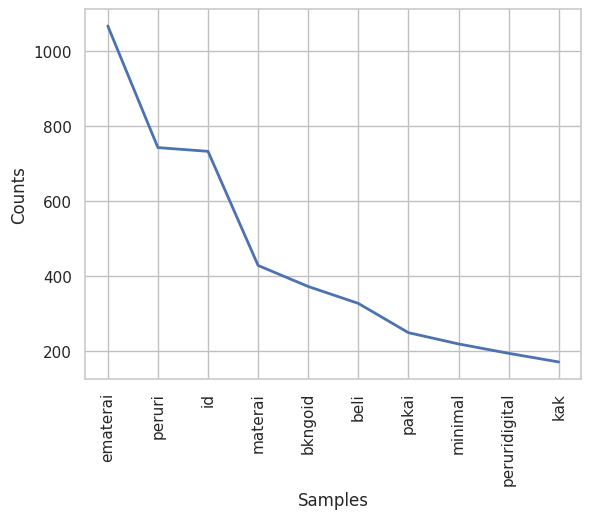

In [ ]:
import matplotlib.pyplot as plt

# plotting
fqdist.plot(10,cumulative=False)
plt.show()

In [ ]:
df_2 = df_clean[['tweet_fix']]
df_2.head()

,tweet_fix
0,peruri id halo kak login ematerai hilang web e...
1,daftar akun ematerai gagal ya
2,skillacademy id halo kak pembubuhan ematerai y...
3,ematerai pakai web commerce bermasalah skill a...
4,ijazah digital peruri langsung diperiksa keasl...


In [ ]:
from wordcloud import WordCloud

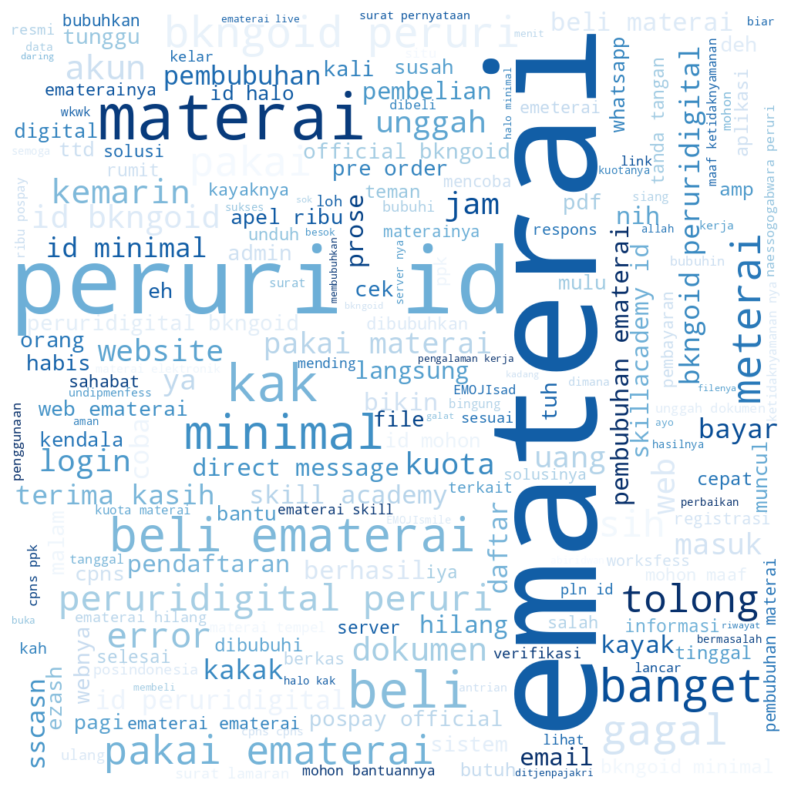

In [ ]:
all_text_s0 = ' '.join(word for word in df_2["tweet_fix"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### sentimen

In [ ]:
!gdown --id 1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ
To: /content/lexicon_positive_ver1.csv
100% 41.4k/41.4k [00:00<00:00, 120MB/s]


In [ ]:
!gdown --id 1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju
To: /content/lexicon_negative_ver1.csv
100% 82.8k/82.8k [00:00<00:00, 121MB/s]


In [ ]:
lexicon_positive = dict()
import csv
with open('lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score >= 0):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'

  return score, polarity

In [ ]:
df_clean['prepos_tweet'] = df_clean.tweet_fix.str.split()

In [ ]:
results = df_clean['prepos_tweet'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
# df_clean['polarity_score'] = results[0]
df_clean['polarity'] = results[1]
print(df_clean['polarity'].value_counts())

negatif    796
positif    719
Name: polarity, dtype: int64


In [ ]:
df['prepos_tweet'] = df_clean.tweet_fix.str.split()

In [ ]:
results = df['prepos_tweet'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]
print(df['polarity'].value_counts())

negatif    796
positif    719
Name: polarity, dtype: int64


In [ ]:
df.head()

,day_name,tanggal,month,year,date,time,full_text,quote_count,reply_count,retweet_count,...,user_id_str,conversation_id_str,username,tweet_url,tag,processedtext,normalization,prepos_tweet,polarity_score,polarity
0,Thu,10,Nov,2022,2022-11-10,09:48:14,"@peruri_id halo kak, ini udah bisa login tapi...",0,15,2,...,53670404,1590642477673112064,heeyowik,https://twitter.com/heeyowik/status/1590642477...,ematerai,peruri id halo kak udah login ematerai hilang ...,peruri id halo kak sudah login ematerai hilang...,"[peruri, id, halo, kak, login, ematerai, hilan...",-3,negatif
1,Tue,26,Sep,2023,2023-09-26,13:03:36,Daftar akun ematerai kok gagal terus yah? Ada ...,0,12,0,...,1191943053046624000,1706655761072546048,terban9jauh,https://twitter.com/terban9jauh/status/1706655...,ematerai,daftar akun ematerai gagal yah,daftar akun ematerai gagal ya,"[daftar, akun, ematerai, gagal, ya]",-2,negatif
2,Sat,7,Oct,2023,2023-10-07,02:11:58,@skillacademy_id Haloooo kak pembubuhan emater...,0,10,0,...,251535471,1710476353584185088,tyatehhtya,https://twitter.com/tyatehhtya/status/17104780...,ematerai,skillacademy id haloo kak pembubuhan ematerai ...,skillacademy id halo kak pembubuhan ematerai y...,"[skillacademy, id, halo, kak, pembubuhan, emat...",2,positif
3,Sat,7,Oct,2023,2023-10-07,02:04:03,ematerai gabisa udah pakai tiga web-commerce p...,0,10,0,...,1068399359648092032,1710476048121390080,husnulhatiimaah,https://twitter.com/husnulhatiimaah/status/171...,ematerai,ematerai gabisa udah pakai web commerce bermas...,ematerai tidak bisa sudah pakai web commerce b...,"[ematerai, pakai, web, commerce, bermasalah, s...",2,positif
4,Sat,5,Aug,2023,2023-08-05,11:57:19,Ijazah digital yang dibuat oleh Peruri dapat l...,1,10,1,...,3326010492,1687794914162355968,peruri_id,https://twitter.com/peruri_id/status/168779491...,ematerai,ijazah digital peruri langsung diperiksa keasl...,ijazah digital peruri langsung diperiksa keasl...,"[ijazah, digital, peruri, langsung, diperiksa,...",-1,negatif


In [ ]:
df.to_excel('result_sentiment.xlsx',index=False)

In [ ]:
df_clean[(df_clean['polarity']=='positif')]

,tweet_clean,tweet_fix,prepos_tweet,polarity
2,"[skillacademy, id, halo, kak, pembubuhan, emat...",skillacademy id halo kak pembubuhan ematerai y...,"[skillacademy, id, halo, kak, pembubuhan, emat...",positif
3,"[ematerai, pakai, web, commerce, bermasalah, s...",ematerai pakai web commerce bermasalah skill a...,"[ematerai, pakai, web, commerce, bermasalah, s...",positif
7,"[sengaja, begadangin, pembubuhan, kuota, keter...",sengaja begadangin pembubuhan kuota keterangan...,"[sengaja, begadangin, pembubuhan, kuota, keter...",positif
11,"[daftar, ppk, pakai, ematerai, server, nya, do...",daftar ppk pakai ematerai server nya downterus...,"[daftar, ppk, pakai, ematerai, server, nya, do...",positif
14,"[dear, peruri, id, istighfar, ya, beli, kuota,...",dear peruri id istighfar ya beli kuota ematera...,"[dear, peruri, id, istighfar, ya, beli, kuota,...",positif
...,...,...,...,...
1502,"[rajarisqullah, peruri, id, eqyrezkiana, halo,...",rajarisqullah peruri id eqyrezkiana halo kak r...,"[rajarisqullah, peruri, id, eqyrezkiana, halo,...",positif
1504,"[arievrahman, bang, percaya, meterai, peruri, ...",arievrahman bang percaya meterai peruri id login,"[arievrahman, bang, percaya, meterai, peruri, ...",positif
1508,"[pembongkaran, gedung, milik, peruri, id, peng...",pembongkaran gedung milik peruri id penghapusa...,"[pembongkaran, gedung, milik, peruri, id, peng...",positif
1511,"[peruri, id, hayo, palsu]",peruri id hayo palsu,"[peruri, id, hayo, palsu]",positif


In [ ]:
df_clean[(df_clean['polarity']=='negatif')]

,tweet_clean,tweet_fix,prepos_tweet,polarity
0,"[peruri, id, halo, kak, login, ematerai, hilan...",peruri id halo kak login ematerai hilang web e...,"[peruri, id, halo, kak, login, ematerai, hilan...",negatif
1,"[daftar, akun, ematerai, gagal, ya]",daftar akun ematerai gagal ya,"[daftar, akun, ematerai, gagal, ya]",negatif
4,"[ijazah, digital, peruri, langsung, diperiksa,...",ijazah digital peruri langsung diperiksa keasl...,"[ijazah, digital, peruri, langsung, diperiksa,...",negatif
5,"[kasian, daftar, sscasn, unggah, dokumen, dise...",kasian daftar sscasn unggah dokumen disertai e...,"[kasian, daftar, sscasn, unggah, dokumen, dise...",negatif
6,"[drama, sih, server, cpns, siang, down, web, e...",drama sih server cpns siang down web ematerai ...,"[drama, sih, server, cpns, siang, down, web, e...",negatif
...,...,...,...,...
1507,"[peruri, id, bayar, qris, terpotong, status, t...",peruri id bayar qris terpotong status terbayar...,"[peruri, id, bayar, qris, terpotong, status, t...",negatif
1509,"[erickthohir, kemenbumn, peruri, id, sepengeta...",erickthohir kemenbumn peruri id sepengetahuan ...,"[erickthohir, kemenbumn, peruri, id, sepengeta...",negatif
1510,"[aset, aset, peruri, id, scrap, besi, tua, inv...",aset aset peruri id scrap besi tua inventaris ...,"[aset, aset, peruri, id, scrap, besi, tua, inv...",negatif
1512,"[peruri, id, tolong, minimal, beli, meterai, k...",peruri id tolong minimal beli meterai kuota be...,"[peruri, id, tolong, minimal, beli, meterai, k...",negatif


In [ ]:
import pandas as pd
import spacy
import networkx as nx                        # a really useful network analysis library
import matplotlib.pyplot as plt
# from networkx.algorithms import community   # not used, yet...
import datetime                              # access to %%time, for timing individual notebook cells
import os

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1515 entries, 0 to 1514
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet_clean   1515 non-null   object
 1   tweet_fix     1515 non-null   object
 2   prepos_tweet  1515 non-null   object
 3   polarity      1515 non-null   object
dtypes: object(4)
memory usage: 47.5+ KB


In [ ]:
nlp = spacy.load('en_core_web_lg')           # A more detailed model (with higher-dimension word vectors) - 13s to load, normally
#nlp = spacy.load('en_core_web_md')           # a smaller model, e.g. for testing

In [ ]:
df['tweet'] = df_clean['tweet_fix'].apply(nlp)

In [ ]:
print(df['tweet'][0].similarity(df['tweet'][1]))
print(df['tweet'][0].similarity(df['tweet'][10]))
print(df['tweet'][1].similarity(df['tweet'][10]))

0.13541930943618896
0.7821109835740623
0.31978483273998487


In [ ]:
# takes 1s for 500 nodes - but of course this won't scale linearly!
raw_G = nx.Graph() # undirected
n = 0


for i in df['tweet']:        # sure, it's inefficient, but it will do
    for j in df['tweet']:
        if i != j:
            if not (raw_G.has_edge(j, i)):
                sim = i.similarity(j)
                raw_G.add_edge(i, j, weight = sim)
                n = n + 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

<ipython-input-77-fdb53a73149e>:10: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.



1515 nodes, and 1146855 edges created.


In [ ]:
edges_to_kill = []
min_wt = 0.94      # this is our cutoff value for a minimum edge-weight

for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt:
            # print('(%.3f)' % (data))
            # print('(%d, %d, %.3f)' % (n, nbr, data))
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr))

print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 1084255.0 edges to kill (of 1146855 ), before de-duplicating


In [ ]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [ ]:
strong_G = raw_G
print(strong_G.number_of_edges())

62600


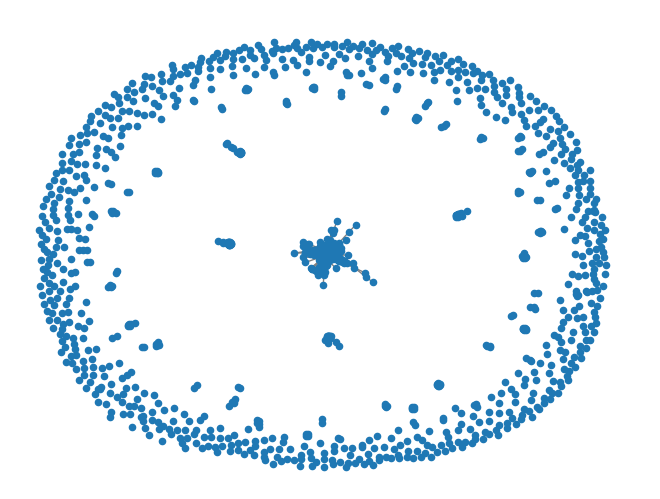

In [ ]:
nx.draw(strong_G, node_size=20, edge_color='gray')

In [ ]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

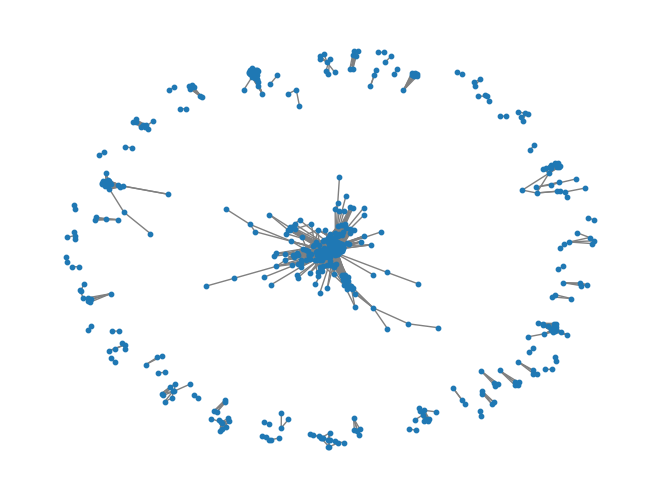

In [ ]:
from math import sqrt
count = strong_G.number_of_nodes()
equilibrium = 10 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos=pos, node_size=10, edge_color='gray')

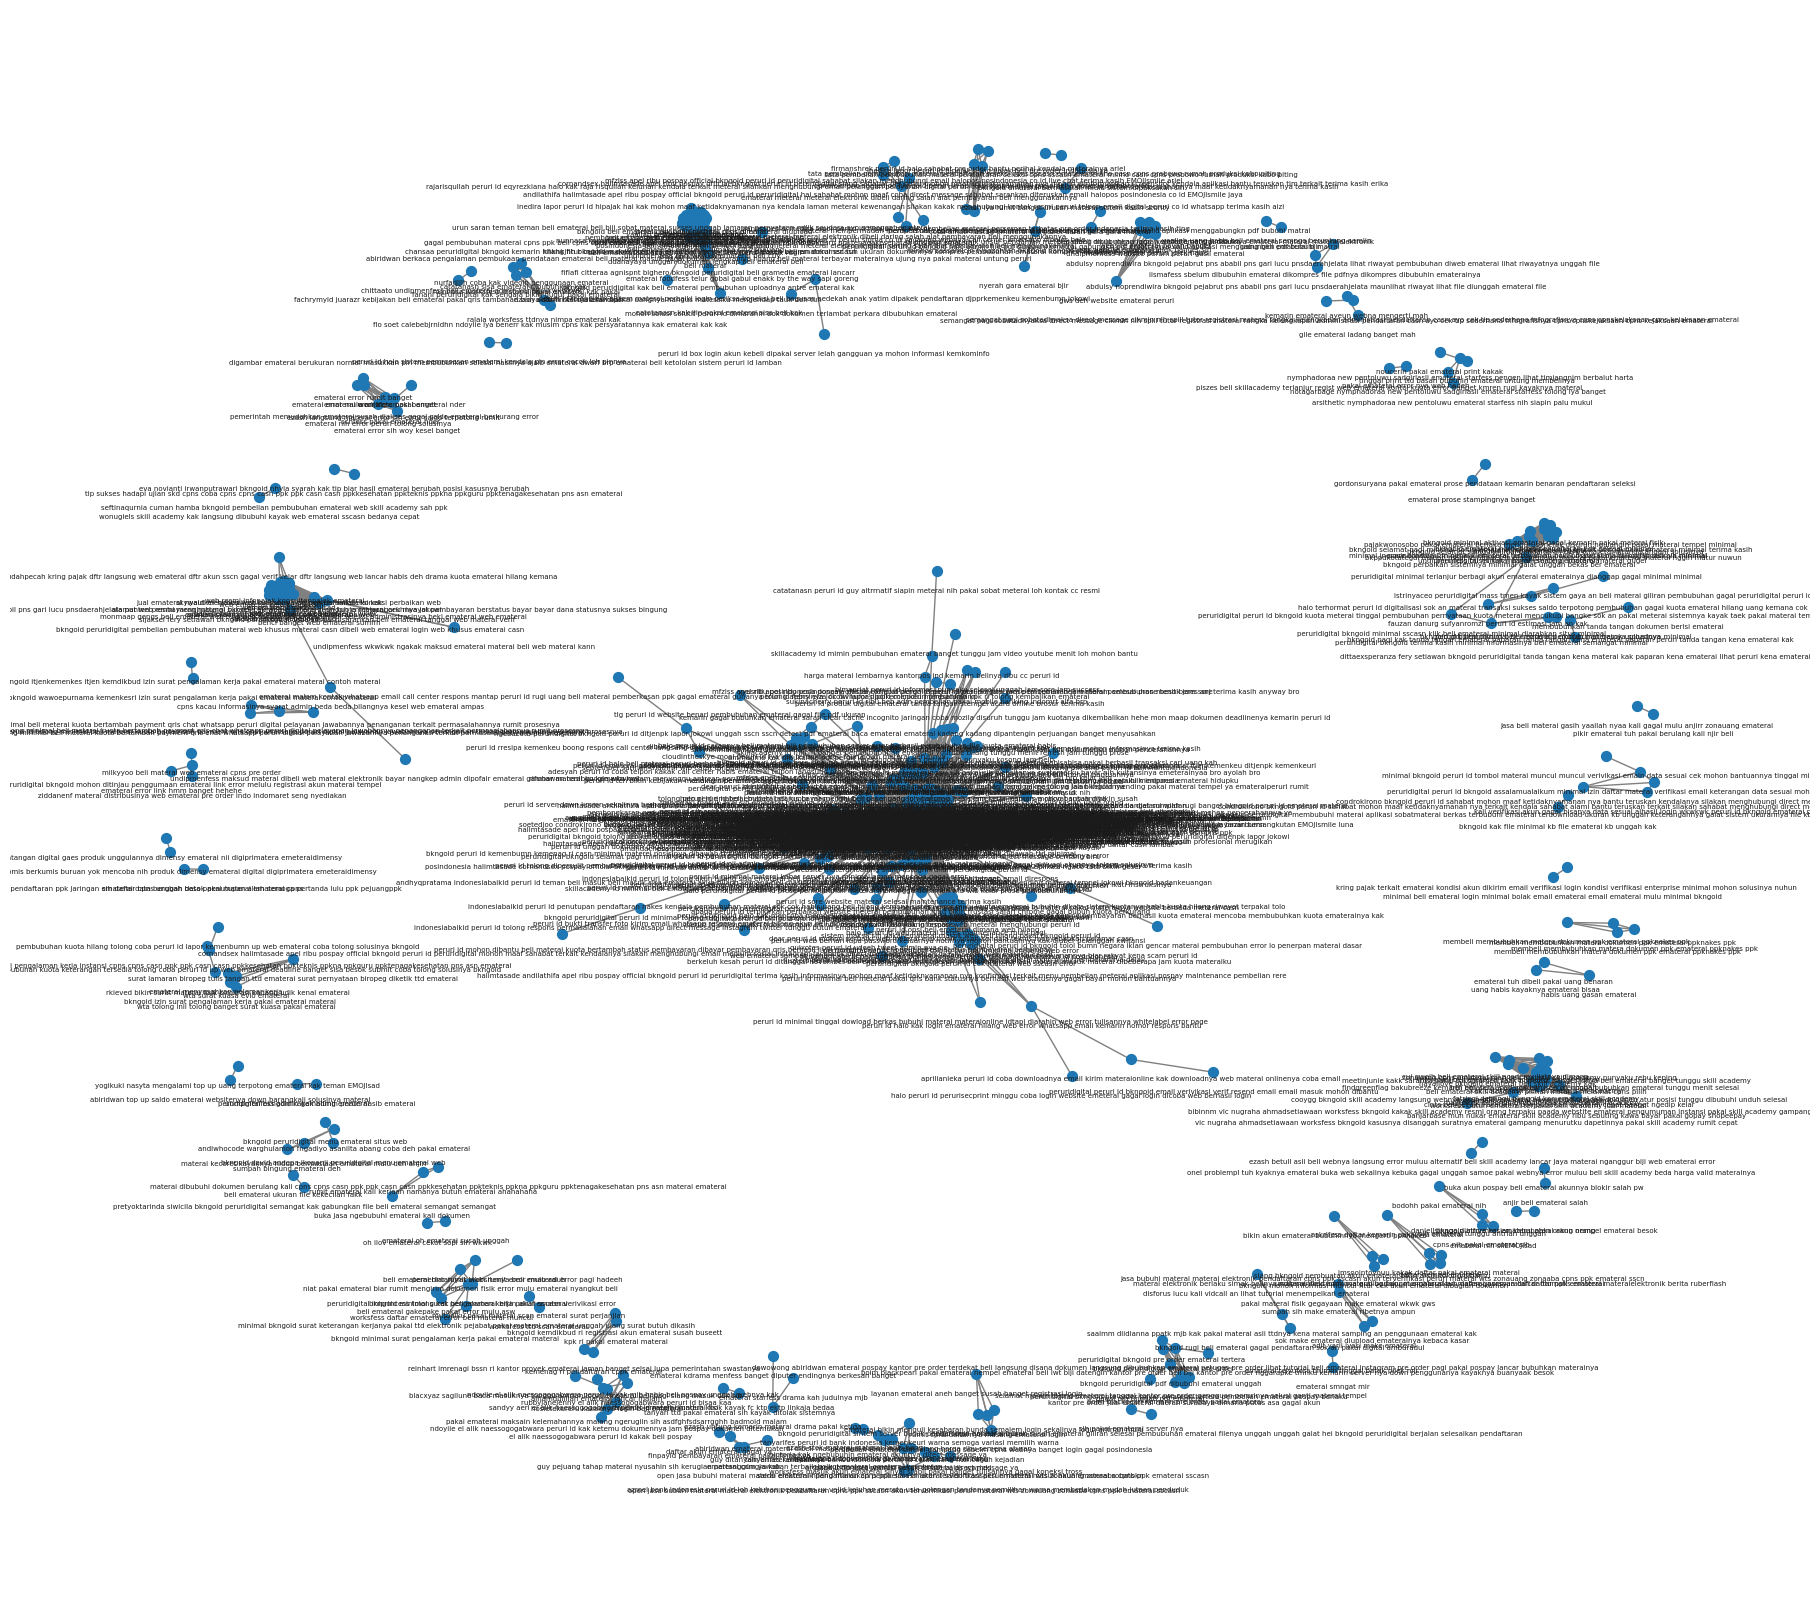

In [ ]:
plt.rcParams['figure.figsize'] = [18, 16]  # a better aspect ratio for labelled nodes

nx.draw(strong_G, pos, font_size=3, node_size=50, edge_color='gray', with_labels=False)
for p in pos:  # raise positions of the labels, relative to the nodes
    pos[p][1] -= 0.03
nx.draw_networkx_labels(strong_G, pos, font_size=5, font_color='k')

plt.show()

In [ ]:
# if n_words=1 -> unigrams, if n_words=2 -> bigrams..
def get_top_Nwords_bigram(corpus, n=None, remove_stop_words=False, n_words=1):
    if remove_stop_words:
        vec = CountVectorizer(stop_words='english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)

    bag_ofWords =vec.transform(corpus)
    sum_words = bag_ofWords.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words_bigram = get_top_Nwords_bigram(df_clean['tweet_fix'].drop_duplicates(), 70, remove_stop_words=True, n_words=2)
for word, freq in common_words_bigram:
    print(word, freq)

peruri id 647
beli ematerai 133
bkngoid peruri 107
pakai ematerai 93
peruridigital peruri 80
id bkngoid 61
pakai materai 53
terima kasih 48
bkngoid peruridigital 46
id minimal 45
skill academy 40
beli materai 40
id peruridigital 37
pembubuhan ematerai 36
direct message 35
skillacademy id 33
peruridigital bkngoid 33
pospay official 32
official bkngoid 30
id peruri 30
pre order 27
web ematerai 26
apel ribu 26
bkngoid minimal 24
id halo 23
ematerai materai 23
tanda tangan 22
id mohon 22
akun ematerai 21
mohon maaf 21
pembubuhan materai 19
surat lamaran 18
ematerai hilang 17
mohon bantuannya 17
materai tempel 17
ematerai skill 17
ematerai error 17
unggah dokumen 16
minimal beli 16
naessogogabwara peruri 16
kuota materai 15
maaf ketidaknyamanan 15
ketidaknyamanan nya 15
ribu pospay 15
kuota ematerai 14
ematerai cpns 14
materai ematerai 14
ematerai beli 14
cpns ppk 14
surat pernyataan 14
id tolong 14
cpns cpns 14
halo kak 13
ematerai gagal 13
server nya 13
id ematerai 13
materai elektronik 1

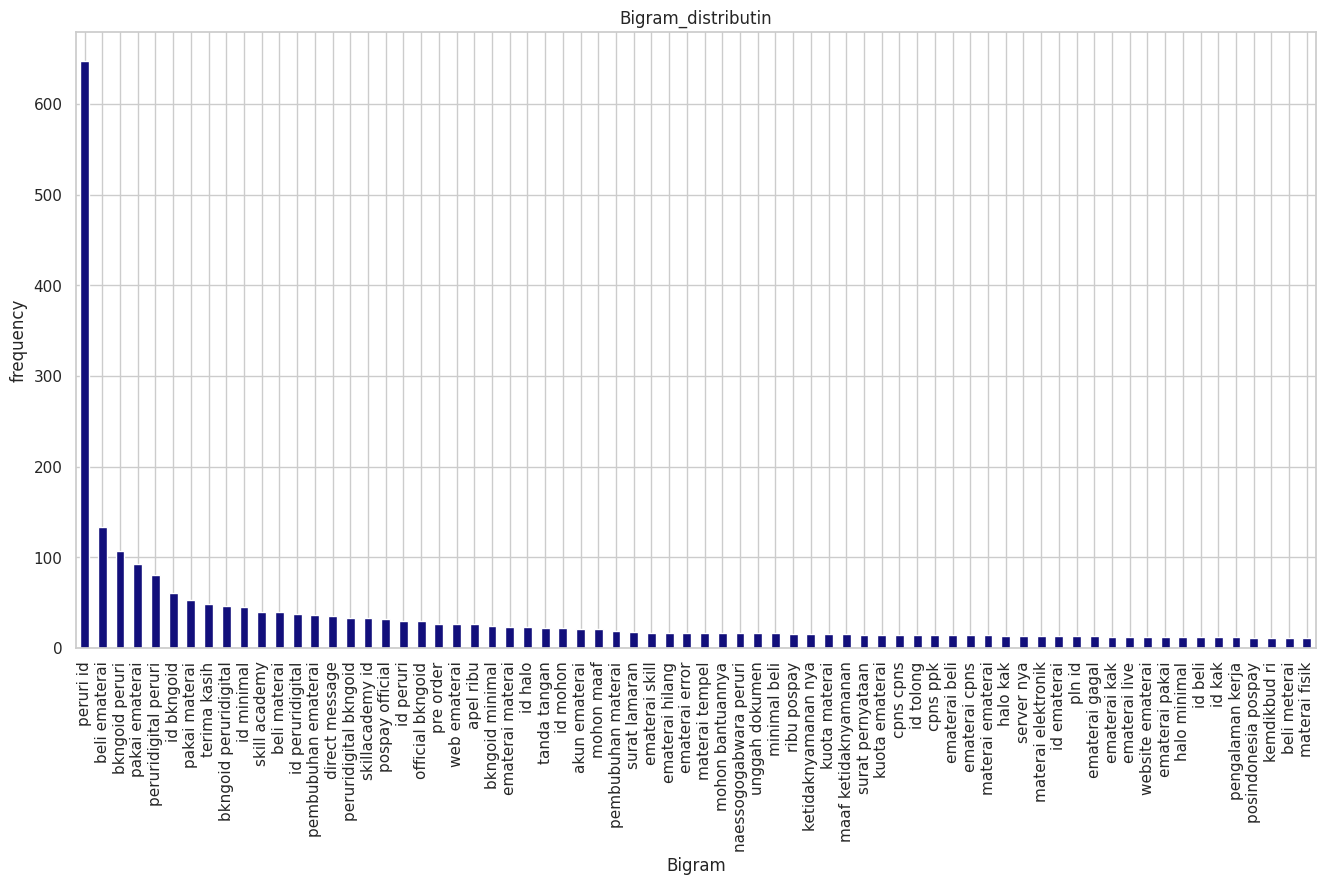

In [ ]:
train_temp =pd.DataFrame(common_words_bigram, columns=['text', 'count'])
fig = plt.figure(figsize=(16,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Bigram_distributin")
ax1.set_xlabel('Bigram')
ax1.set_ylabel("frequency")
plt.show()

In [ ]:
common_words = get_top_Nwords_bigram(df_clean['tweet_fix'].drop_duplicates(), 100, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

bkngoid peruri id 106
peruridigital peruri id 80
peruri id bkngoid 61
peruri id peruridigital 36
peruri id minimal 31
pospay official bkngoid 30
official bkngoid peruri 30
id peruri id 26
bkngoid peruridigital peruri 23
peruri id halo 21
peruri id mohon 21
peruri id peruri 20
ematerai skill academy 17
naessogogabwara peruri id 16
maaf ketidaknyamanan nya 15
apel ribu pospay 15
ribu pospay official 15
mohon maaf ketidaknyamanan 14
peruri id tolong 14
skillacademy id minimal 13
peruri id ematerai 12
minimal beli ematerai 12
posindonesia pospay official 11
peruri id kak 11
pakai materai tempel 10
pakai ematerai materai 10
indonesiabaikid peruri id 10
peruri id beli 10
posindonesia bkngoid peruri 10
cpns cpns casn 10
cpns casn ppk 10
casn ppk ppk 10
ppk ppk casn 10
ppk casn casn 10
casn casn ppkkesehatan 10
casn ppkkesehatan ppkteknis 10
ppkkesehatan ppkteknis ppkna 10
ppkteknis ppkna ppkguru 10
ppkna ppkguru ppktenagakesehatan 10
ppkguru ppktenagakesehatan pns 10
ppktenagakesehatan pns as

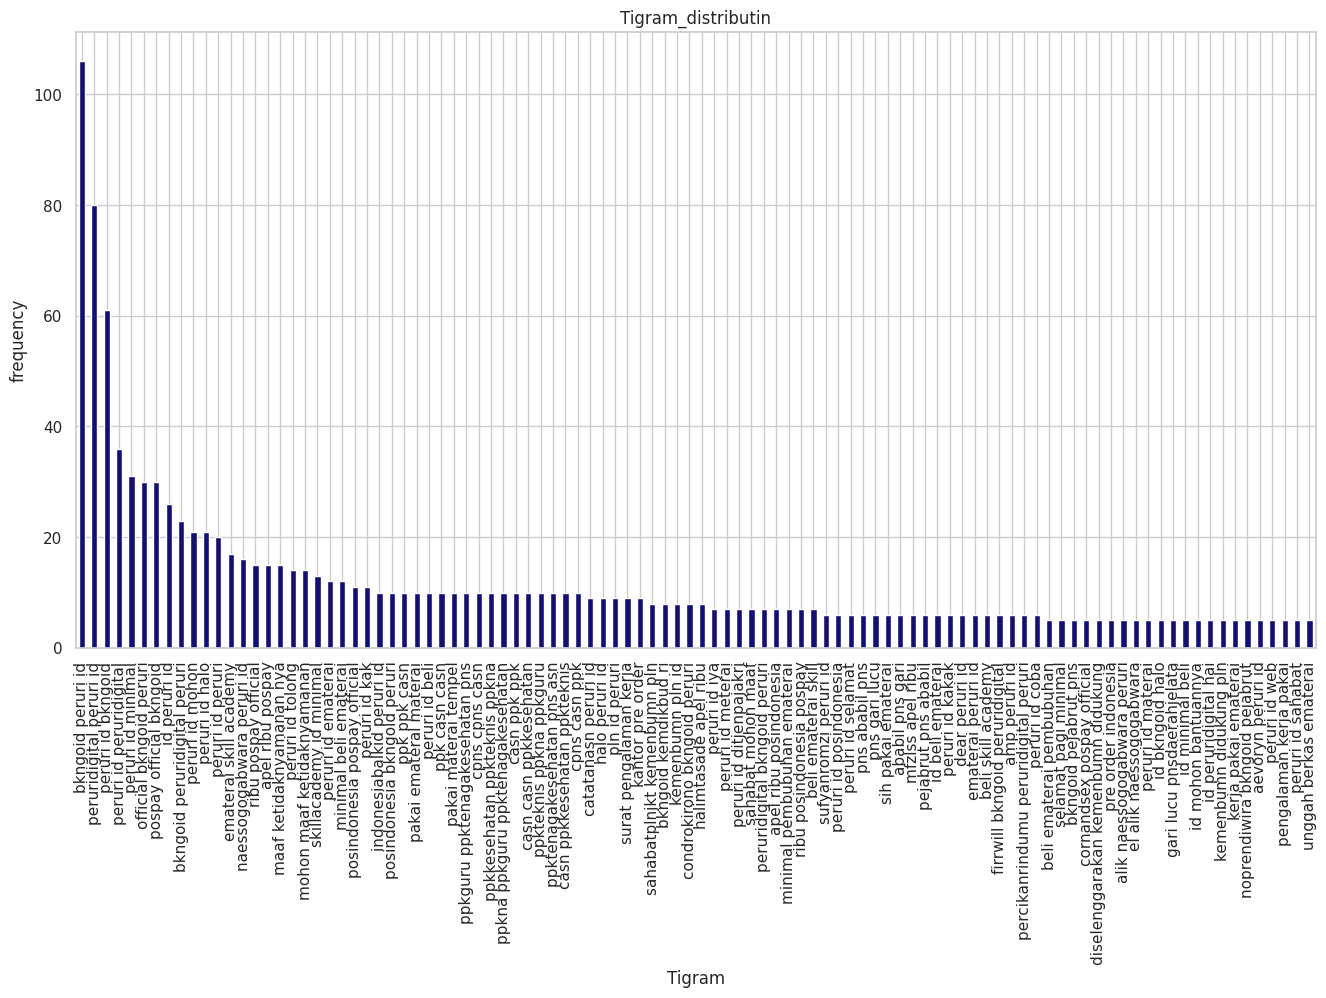

In [ ]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(16,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Tigram_distributin")
ax1.set_xlabel('Tigram')
ax1.set_ylabel("frequency")
plt.show()

In [ ]:
common_words_bigram = get_top_Nwords_bigram(df_clean['tweet_fix'].drop_duplicates(), remove_stop_words=True, n_words=3)

In [ ]:
common_words_bigram = pd.DataFrame(common_words_bigram)

In [ ]:
common_words_bigram.to_excel('tigram_emet.xlsx', index=False)